In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
import pickle

## Combining two datasets

In [2]:
# with combined dataset
data_flu = pd.read_csv("large_data.csv")

columns_to_drop = ['ITCHY_NOSE', 'ITCHY_EYES', 'ITCHY_MOUTH', 'ITCHY_INNER_EAR', 'PINK_EYE', 'NAUSEA', 'VOMITING', 'SHORTNESS_OF_BREATH', 'LOSS_OF_TASTE', 'LOSS_OF_SMELL', 'SNEEZING']
df_flu = data_flu.drop(columns=columns_to_drop)

df_flu = df_flu[df_flu['TYPE'] == 'FLU']
df_flu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 19453 to 44452
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   COUGH                 25000 non-null  int64 
 1   MUSCLE_ACHES          25000 non-null  int64 
 2   TIREDNESS             25000 non-null  int64 
 3   SORE_THROAT           25000 non-null  int64 
 4   RUNNY_NOSE            25000 non-null  int64 
 5   STUFFY_NOSE           25000 non-null  int64 
 6   FEVER                 25000 non-null  int64 
 7   DIARRHEA              25000 non-null  int64 
 8   DIFFICULTY_BREATHING  25000 non-null  int64 
 9   TYPE                  25000 non-null  object
dtypes: int64(9), object(1)
memory usage: 2.1+ MB


In [3]:
data_flu_size = df_flu.shape[0]

In [4]:
X_flu = np.asarray(df_flu)[:,:-1]
y_flu = np.asarray(df_flu)[:,-1]

In [7]:
data_covid = pd.read_csv("Cleaned-Data.csv")

columns_to_keep = ['Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing', 'Sore-Throat', 'Pains', 'Nasal-Congestion', 'Runny-Nose', 'Diarrhea']
df_covid = data_covid[columns_to_keep]

In [8]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   Fever                    316800 non-null  int64
 1   Tiredness                316800 non-null  int64
 2   Dry-Cough                316800 non-null  int64
 3   Difficulty-in-Breathing  316800 non-null  int64
 4   Sore-Throat              316800 non-null  int64
 5   Pains                    316800 non-null  int64
 6   Nasal-Congestion         316800 non-null  int64
 7   Runny-Nose               316800 non-null  int64
 8   Diarrhea                 316800 non-null  int64
dtypes: int64(9)
memory usage: 21.8 MB


In [9]:
df_covid = df_covid[['Dry-Cough', 'Pains', 'Tiredness', 'Sore-Throat', 'Runny-Nose', 'Nasal-Congestion', 'Fever', 'Diarrhea', 'Difficulty-in-Breathing']]

df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   Dry-Cough                316800 non-null  int64
 1   Pains                    316800 non-null  int64
 2   Tiredness                316800 non-null  int64
 3   Sore-Throat              316800 non-null  int64
 4   Runny-Nose               316800 non-null  int64
 5   Nasal-Congestion         316800 non-null  int64
 6   Fever                    316800 non-null  int64
 7   Diarrhea                 316800 non-null  int64
 8   Difficulty-in-Breathing  316800 non-null  int64
dtypes: int64(9)
memory usage: 21.8 MB


In [10]:
df_covid = df_covid.sample(n=data_flu_size)

X_covid = np.asarray(df_covid)
y_covid = np.full(data_flu_size, "COVID")

In [11]:
X = np.concatenate([X_flu, X_covid])
y = np.concatenate([y_flu, y_covid])

# preprocessing - ICA
transformer = FastICA(n_components=2, random_state=42, whiten='unit-variance')
X_transformed = transformer.fit_transform(X)

## EDA

In [15]:
# Concatenating X and y for EDA purposes
y_dummy = np.reshape(y, (y.shape[0], 1))
final_dataset = np.hstack((X, y_dummy))

# Converting to pandas DataFrame
column_names = ['Dry-Cough', 'Pains', 'Tiredness', 'Sore-Throat', 'Runny-Nose', 'Nasal-Congestion', 'Fever', 'Diarrhea', 'Difficulty-in-Breathing', 'Type']
df_dataset = pd.DataFrame(final_dataset, columns=column_names)

In [16]:
df_dataset.head()

,Dry-Cough,Pains,Tiredness,Sore-Throat,Runny-Nose,Nasal-Congestion,Fever,Diarrhea,Difficulty-in-Breathing,Type
0,1,0,0,0,1,1,1,0,0,FLU
1,0,1,1,1,0,0,1,0,0,FLU
2,0,0,0,1,1,1,0,0,1,FLU
3,1,0,1,0,0,1,0,0,0,FLU
4,1,1,1,1,1,0,1,1,1,FLU


### Checking Illegal Values

In [17]:
# Check for unique values in each feature column
illegal_values = df_dataset.iloc[:, :-1].apply(lambda col: col.isin([0, 1]).all())

# Display columns that contain illegal values
invalid_columns = illegal_values[illegal_values == False]

if not invalid_columns.empty:
    print("Columns with illegal values (values other than 0 or 1):")
    print(invalid_columns.index.tolist())

    # Optionally, show the count of illegal values in these columns
    for col in invalid_columns.index:
        print(f"\nIllegal value count in '{col}':")
        print(df_dataset[col][~df_dataset[col].isin([0, 1])].value_counts())
else:
    print("No illegal values found in the feature columns.")

No illegal values found in the feature columns.


### Statistical Summary

In [18]:
df_dataset.describe()

,Dry-Cough,Pains,Tiredness,Sore-Throat,Runny-Nose,Nasal-Congestion,Fever,Diarrhea,Difficulty-in-Breathing,Type
count,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000
unique,2,2,2,2,2,2,2,2,2,2
top,1,0,1,0,1,1,0,0,1,FLU
freq,27601,27423,25848,28889,27036,27021,29260,27622,25884,25000


### Symptom Occurance Frequency

In [20]:
# Total number of rows in the DataFrame
df_feat = df_dataset.iloc[:, :-1]

total_rows = len(df_feat)

# Calculate the ratio of 1s in each column
ratios = df_feat.sum() / total_rows

print("Ratio of 1s in each column:")
print(ratios)

Ratio of 1s in each column:
Dry-Cough                  0.55202
Pains                      0.45154
Tiredness                  0.51696
Sore-Throat                0.42222
Runny-Nose                 0.54072
Nasal-Congestion           0.54042
Fever                       0.4148
Diarrhea                   0.44756
Difficulty-in-Breathing    0.51768
dtype: object


### Correlations with Class Label

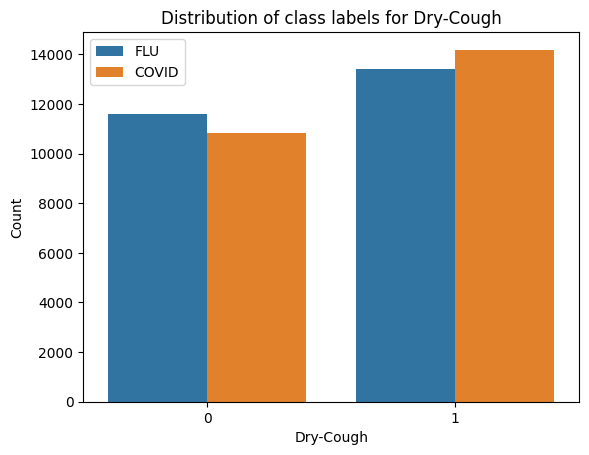

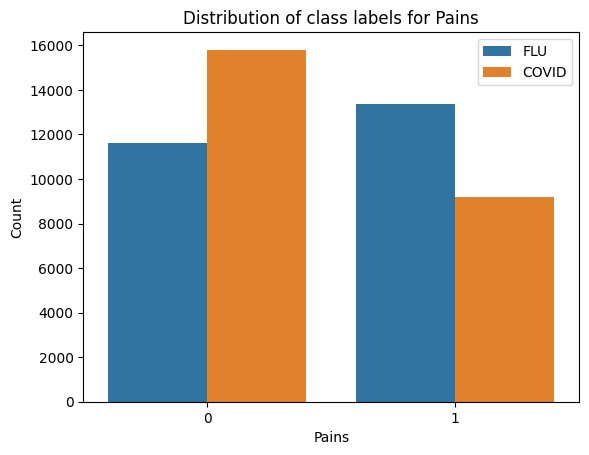

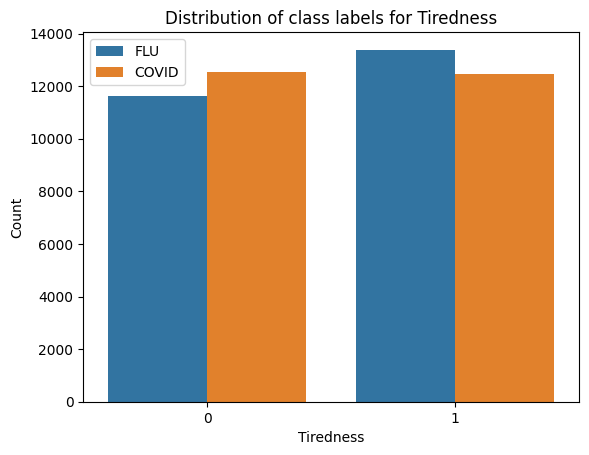

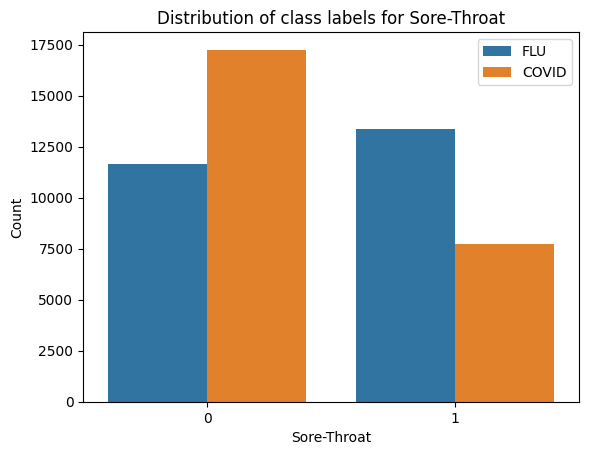

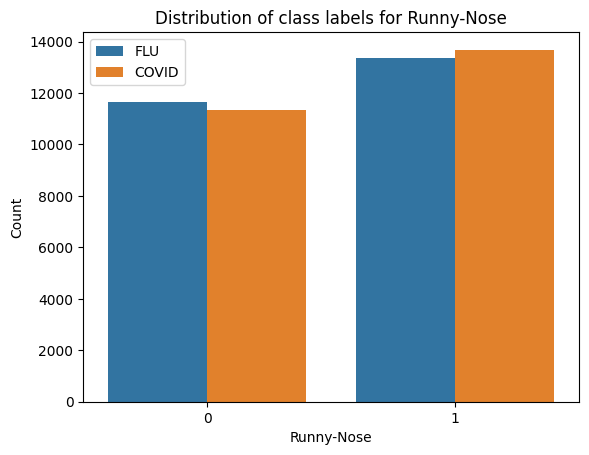

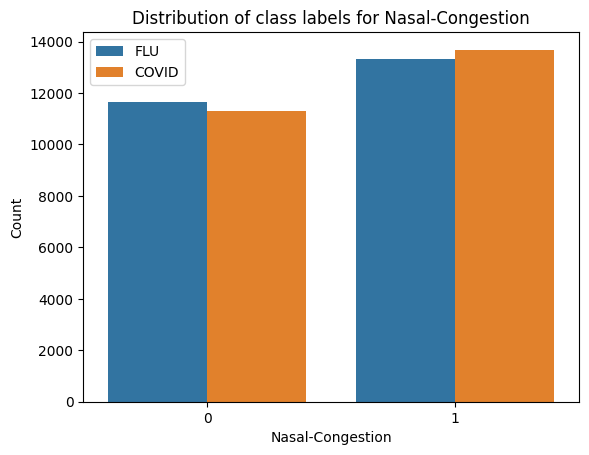

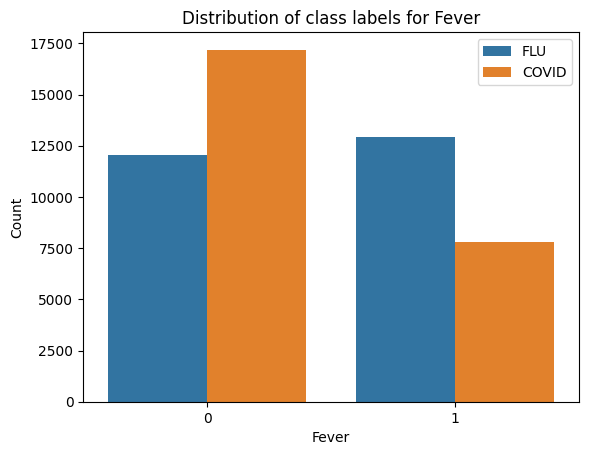

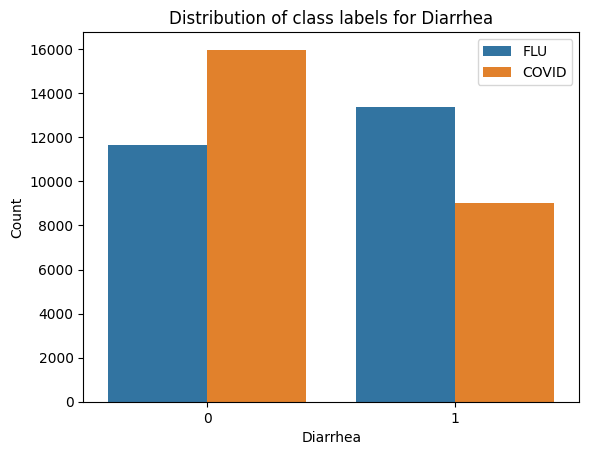

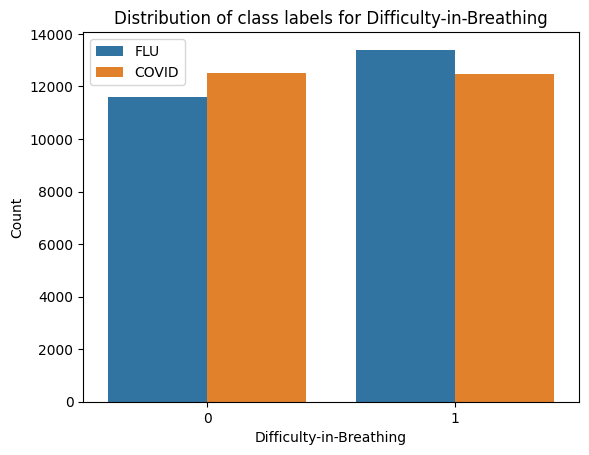

In [22]:
# With exact counts
import seaborn as sns
import matplotlib.pyplot as plt

for feat in df_dataset.iloc[:, :-1].columns.tolist():

    # Plot the distribution of class labels for a specific binary feature

    plt.figure()
    sns.countplot(data=df_dataset, x=feat, hue='Type')
    plt.title(f'Distribution of class labels for {feat}')
    plt.xlabel(f'{feat}')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

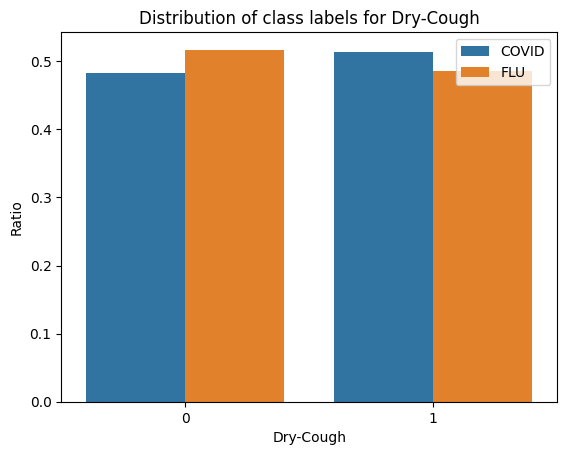

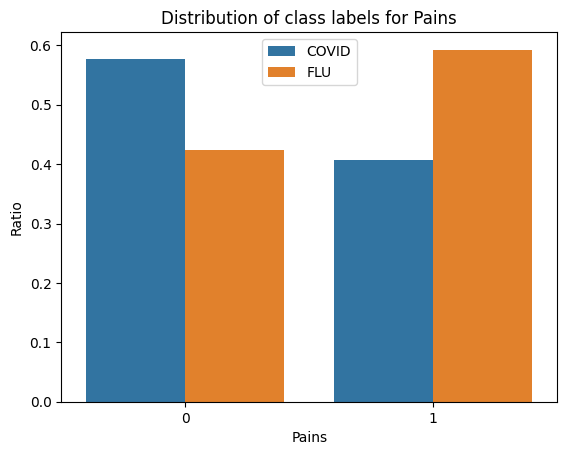

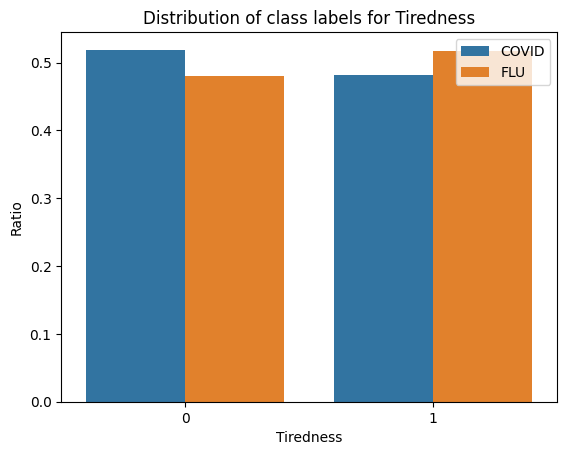

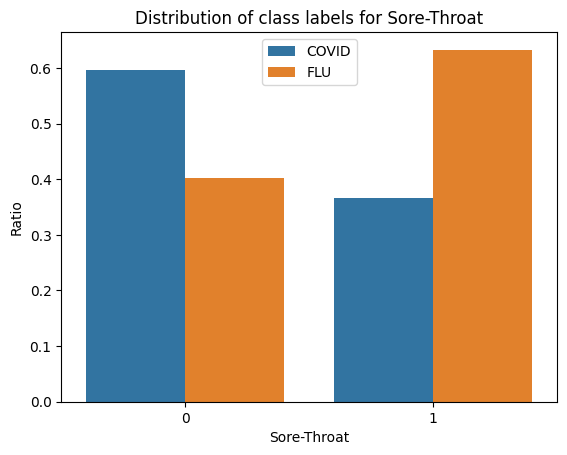

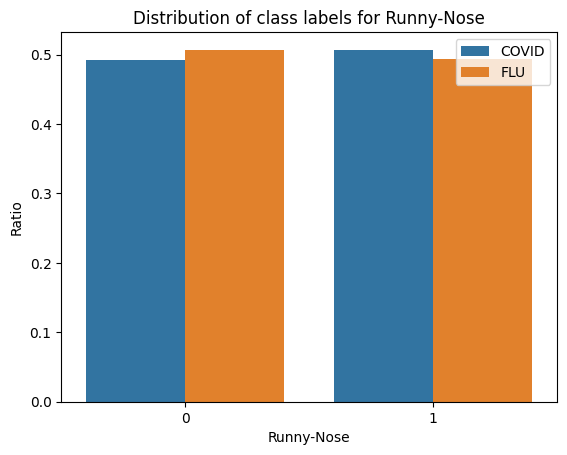

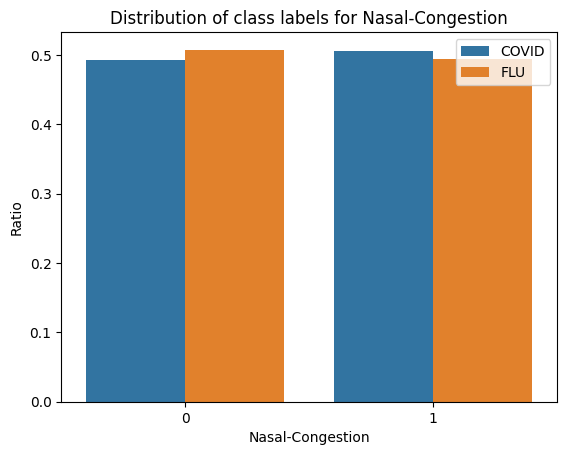

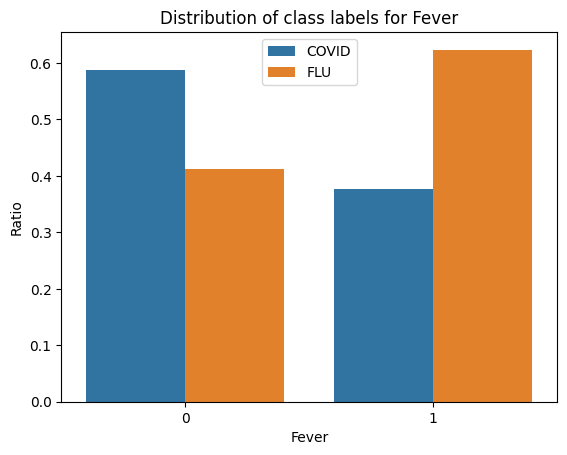

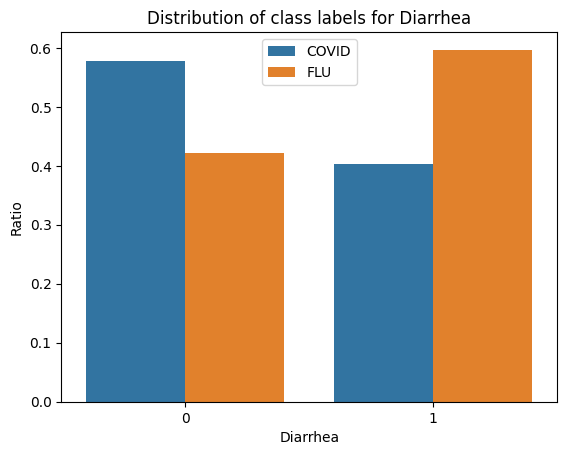

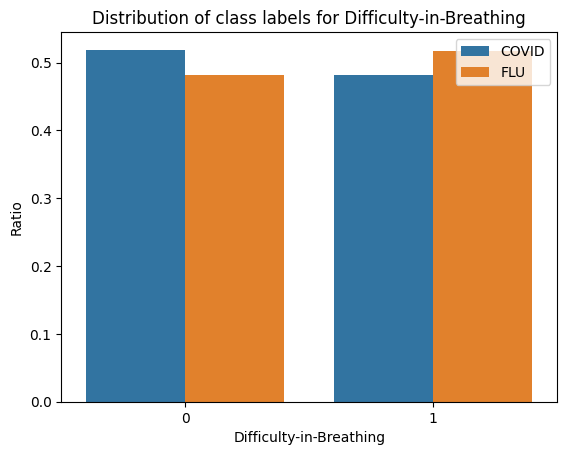

In [23]:
# With relative frequencies
import seaborn as sns
import matplotlib.pyplot as plt

# Iterate through each binary feature (excluding the last column if it is the target)
for feat in df_dataset.iloc[:, :-1].columns.tolist():

    # Calculate the total count for each feature value
    feature_counts = df_dataset.groupby([feat, 'Type']).size().reset_index(name='count')

    # Calculate the ratios by dividing the count by the total counts per feature value
    feature_counts['ratio'] = feature_counts.groupby(feat)['count'].transform(lambda x: x / x.sum())

    # Plot the distribution of ratios
    plt.figure()
    sns.barplot(data=feature_counts, x=feat, y='ratio', hue='Type')
    plt.title(f'Distribution of class labels for {feat}')
    plt.xlabel(f'{feat}')
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()

In [24]:
# Mutual Information

from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Calculate mutual information between each binary feature and the label
df_X = df_dataset.iloc[:, :-1]  # Features (all columns except the label)
df_y = df_dataset['Type']  # Label column

# Compute mutual information scores
mi_scores = mutual_info_classif(df_X, df_y, discrete_features=True)

# Organize scores into a DataFrame for easy reading
mi_df = pd.DataFrame({'Feature': df_X.columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

                   Feature  Mutual Information
3              Sore-Throat            0.026080
6                    Fever            0.021759
7                 Diarrhea            0.015261
1                    Pains            0.014173
2                Tiredness            0.000681
8  Difficulty-in-Breathing            0.000669
0                Dry-Cough            0.000473
5         Nasal-Congestion            0.000096
4               Runny-Nose            0.000086


### Correlation among features

In [26]:
# Cramer's V
# 0 --> no association
# 1 --> strong association

'''
0.1 or lower: Weak association.
0.1 to 0.3: Moderate association.
Above 0.3: Strong association.
'''

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Function to calculate Cramér's V
def cramers_v(x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(x, y)

    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Calculate Cramér's V
    n = contingency_table.sum().sum()  # Total sample size
    k = min(contingency_table.shape) - 1  # Smaller dimension minus 1
    return np.sqrt(chi2 / (n * k))

df = df_dataset.iloc[:, :-1]

# Create an empty DataFrame to store the Cramér's V values
cramers_v_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate Cramér's V for each pair of features
for col1 in df.columns:
    for col2 in df.columns:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0  # Perfect association with itself
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Convert values to float for better display
cramers_v_matrix = cramers_v_matrix.astype(float)

print("Cramér's V Matrix:")
print(cramers_v_matrix)

Cramér's V Matrix:
                         Dry-Cough     Pains  Tiredness  Sore-Throat  \
Dry-Cough                 1.000000  0.015634   0.177536     0.006254   
Pains                     0.015634  1.000000   0.003531     0.032958   
Tiredness                 0.177536  0.003531   1.000000     0.065559   
Sore-Throat               0.006254  0.032958   0.065559     1.000000   
Runny-Nose                0.009355  0.043012   0.009881     0.015328   
Nasal-Congestion          0.008121  0.142288   0.009258     0.012456   
Fever                     0.011396  0.032348   0.195348     0.029945   
Diarrhea                  0.009997  0.060785   0.001366     0.025087   
Difficulty-in-Breathing   0.178038  0.004597   0.007649     0.189282   

                         Runny-Nose  Nasal-Congestion     Fever  Diarrhea  \
Dry-Cough                  0.009355          0.008121  0.011396  0.009997   
Pains                      0.043012          0.142288  0.032348  0.060785   
Tiredness                  0.

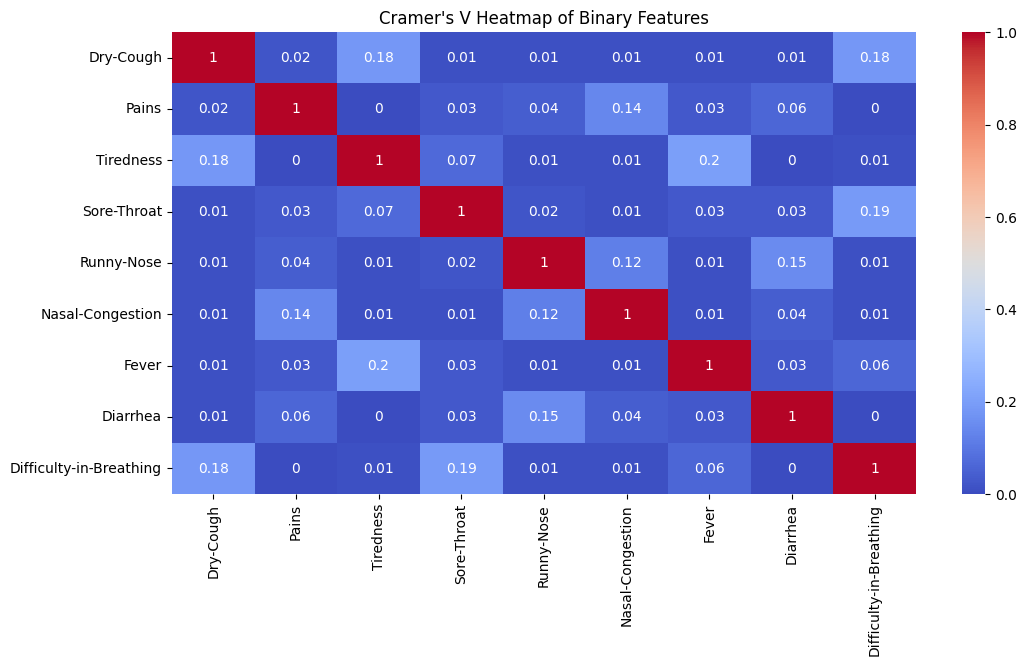

In [27]:
# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cramers_v_matrix.round(2), annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Cramer's V Heatmap of Binary Features")
plt.show()

## Model Training and Testing

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)

In [34]:
# RANDOM FOREST
estimator_num = [50, 100, 200]
acc_record = []

current_max_acc = 0
current_best_num = None

for n in estimator_num:

  # Following code was taken from the Assignment 2 Part 1 [7]
  scores = []
  for train_index, test_index in cv.split(X_train):

      X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
      clf = RandomForestClassifier(n_estimators=n)
      clf.fit(X_cv_train, y_cv_train)
      scores.append(clf.score(X_cv_test, y_cv_test))

  mean_acc = np.mean(scores)
  acc_record.append(mean_acc)

  if mean_acc > current_max_acc:
      current_max_acc = mean_acc
      current_best_num = n

print("Best accuracy: {acc} obtained with when number of estimators is {num}".format(acc=current_max_acc, num=current_best_num))

Best accuracy: 0.8401428571428571 obtained with when number of estimators is 50


In [39]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
rf_scores = rf.score(X_test, y_test)

In [40]:
print(rf_scores)

0.8408


In [36]:
# KNN
neighbour_num = [3, 7, 15]
acc_record = []

current_max_acc = 0
current_best_num = None

for n in neighbour_num:

  # Following code was taken from the Assignment 2 Part 1 [7]
  scores = []
  for train_index, test_index in cv.split(X_train):

      X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
      clf = KNeighborsClassifier(n_neighbors=n)
      clf.fit(X_cv_train, y_cv_train)
      scores.append(clf.score(X_cv_test, y_cv_test))

  mean_acc = np.mean(scores)
  acc_record.append(mean_acc)

  if mean_acc > current_max_acc:
      current_max_acc = mean_acc
      current_best_num = n

print("Best accuracy: {acc} obtained with when number of neighbors is {num}".format(acc=current_max_acc, num=current_best_num))

Best accuracy: 0.833657142857143 obtained with when number of neighbors is 15


In [41]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.8330666666666666

In [38]:
# LINEAR SVM
# Following code was taken from the Assignment 2 Part 1 [7]
from sklearn.svm import SVC

C_values = [10**exp for exp in range(-8, 9, 3)]

acc_record = []

current_max_acc = 0
current_best_c = None

for c in C_values:

  scores = []
  for train_index, test_index in cv.split(X_train):

      X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
      clf = LinearSVC(C=c)
      clf.fit(X_cv_train, y_cv_train)
      scores.append(clf.score(X_cv_test, y_cv_test))

  mean_acc = np.mean(scores)
  acc_record.append(mean_acc)

  if mean_acc > current_max_acc:
    current_max_acc = mean_acc
    current_best_c = c

print("Best accuracy score is {acc}, found with C = {c_val}.".format(acc=current_max_acc, c_val=current_best_c))

Best accuracy score is 0.6565714285714286, found with C = 10.


In [42]:
lsvc = LinearSVC(C=10)
lsvc.fit(X_train, y_train)
lsvc.score(X_test, y_test)

0.6560666666666667

In [43]:
# LOGISTIC REGRESSION
lr = LogisticRegression(multi_class='multinomial')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


0.6579333333333334

In [44]:
# MULTILAYER PERCEPTRON
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)

0.8408

In [45]:
# save models using pickle
lr_file_name = "lr_combined_ds_no_preproc.pkl"
lsvc_file_name = "lsvc_combined_ds_no_preproc.pkl"
rf_file_name = "rf_combined_ds_no_preproc.pkl"
knn_file_name = "knn_combined_ds_no_preproc.pkl"
mlp_file_name = "mlp_combined_ds_no_preproc.pkl"

all_file_names = [lr_file_name, lsvc_file_name, rf_file_name, knn_file_name, mlp_file_name]
all_classifiers = [lr, lsvc, rf, knn, mlp]

for index, file_name in enumerate(all_file_names):
    with open(file_name, 'wb') as file:
        pickle.dump(all_classifiers[index], file)

## Model Training and Testing with Preprocess

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

In [47]:
print(X_transformed)

[[ 0.27495513 -1.00184863]
 [ 0.6037503  -0.5682959 ]
 [-1.77440005  0.72869787]
 ...
 [ 0.93868936  0.97378998]
 [-1.68213577 -0.35424658]
 [ 1.45649419  0.08721234]]


In [48]:
# RANDOM FOREST
estimator_num = [50, 100, 200]
acc_record = []

current_max_acc = 0
current_best_num = None

for n in estimator_num:

  # Following code was taken from the Assignment 2 Part 1 [7]
  scores = []
  for train_index, test_index in cv.split(X_train):

      X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
      clf = RandomForestClassifier(n_estimators=n)
      clf.fit(X_cv_train, y_cv_train)
      scores.append(clf.score(X_cv_test, y_cv_test))

  mean_acc = np.mean(scores)
  acc_record.append(mean_acc)

  if mean_acc > current_max_acc:
      current_max_acc = mean_acc
      current_best_num = n

print("Best accuracy: {acc} obtained with when number of estimators is {num}".format(acc=current_max_acc, num=current_best_num))

Best accuracy: 0.8401428571428571 obtained with when number of estimators is 50


In [49]:
rf_preproc = RandomForestClassifier(n_estimators=50)
rf_preproc.fit(X_train, y_train)
rf_preproc.score(X_test, y_test)

0.8408

In [50]:
# KNN
neighbour_num = [3, 7, 15]
acc_record = []

current_max_acc = 0
current_best_num = None

for n in neighbour_num:

  # Following code was taken from the Assignment 2 Part 1 [7]
  scores = []
  for train_index, test_index in cv.split(X_train):

      X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
      clf = KNeighborsClassifier(n_neighbors=n)
      clf.fit(X_cv_train, y_cv_train)
      scores.append(clf.score(X_cv_test, y_cv_test))

  mean_acc = np.mean(scores)
  acc_record.append(mean_acc)

  if mean_acc > current_max_acc:
      current_max_acc = mean_acc
      current_best_num = n

print("Best accuracy: {acc} obtained with when number of neighbors is {num}".format(acc=current_max_acc, num=current_best_num))

Best accuracy: 0.8339714285714287 obtained with when number of neighbors is 15


In [51]:
knn_preproc = KNeighborsClassifier(n_neighbors=15)
knn_preproc.fit(X_train, y_train)
knn_preproc.score(X_test, y_test)

0.8368

In [52]:
# LINEAR SVM
# Following code was taken from the Assignment 2 Part 1 [7]
from sklearn.svm import SVC

C_values = [10**exp for exp in range(-8, 9, 3)]

acc_record = []

current_max_acc = 0
current_best_c = None

for c in C_values:

  scores = []
  for train_index, test_index in cv.split(X_train):

      X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
      clf = LinearSVC(C=c)
      clf.fit(X_cv_train, y_cv_train)
      scores.append(clf.score(X_cv_test, y_cv_test))

  mean_acc = np.mean(scores)
  acc_record.append(mean_acc)

  if mean_acc > current_max_acc:
    current_max_acc = mean_acc
    current_best_c = c

print("Best accuracy score is {acc}, found with C = {c_val}.".format(acc=current_max_acc, c_val=current_best_c))

Best accuracy score is 0.5330285714285714, found with C = 0.01.


In [53]:
lsvc_preproc = LinearSVC(C=0.01)
lsvc_preproc.fit(X_train, y_train)
lsvc_preproc.score(X_test, y_test)

0.5385333333333333

In [54]:
# LOGISTIC REGRESSION
lr_preproc = LogisticRegression(multi_class='multinomial')
lr_preproc.fit(X_train, y_train)
lr_preproc.score(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


0.5385333333333333

In [55]:
# MULTILAYER PERCEPTRON
mlp_preproc = MLPClassifier()
mlp_preproc.fit(X_train, y_train)
mlp_preproc.score(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6849333333333333

In [56]:
# MULTILAYER PERCEPTRON
mlp_preproc = MLPClassifier(max_iter=400)
mlp_preproc.fit(X_train, y_train)
mlp_preproc.score(X_test, y_test)

0.6776666666666666

In [57]:
# save models using pickle
lr_file_name = "lr_combined_ds_with_preproc.pkl"
lsvc_file_name = "lsvc_combined_ds_with_preproc.pkl"
rf_file_name = "rf_combined_ds_with_preproc.pkl"
knn_file_name = "knn_combined_ds_with_preproc.pkl"
mlp_file_name = "mlp_combined_ds_with_preproc.pkl"

all_file_names = [lr_file_name, lsvc_file_name, rf_file_name, knn_file_name, mlp_file_name]
all_classifiers = [lr_preproc, lsvc_preproc, rf_preproc, knn_preproc, mlp_preproc]

for index, file_name in enumerate(all_file_names):
    with open(file_name, 'wb') as file:
        pickle.dump(all_classifiers[index], file)

## Confusion Matrix

Just for the best model: Random Forest in both cases

In [58]:
# ChatGPT [1] help for sklearn and confusion matrix syntax

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Training-test split on dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training model on optimal hyperparameter
classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(X_train, y_train)

# Predicting on test set
y_pred = classifier.predict(X_test)

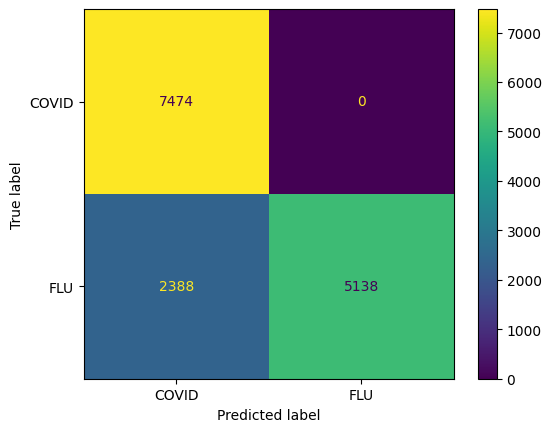

In [60]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

# Show the plot
import matplotlib.pyplot as plt
plt.show()

In [61]:
# ChatGPT [1] help for sklearn and confusion matrix syntax

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Training-test split on dataset
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

# Training model on optimal hyperparameter
classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(X_train, y_train)

# Predicting on test set
y_pred = classifier.predict(X_test)

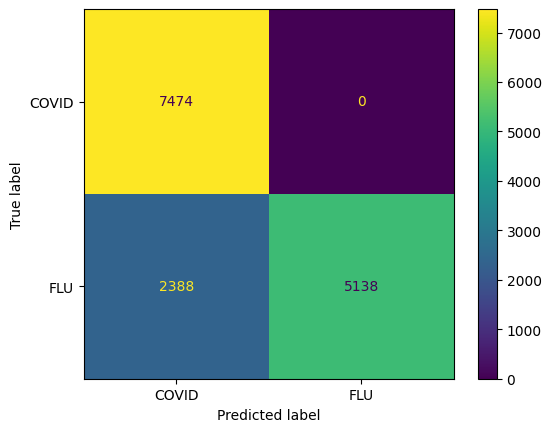

In [62]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

# Show the plot
import matplotlib.pyplot as plt
plt.show()

## Mislabeling Effect

Trying on finetuned models with best performances

In [64]:
# 25% flip

import numpy as np

# Determine unique classes
unique_classes = np.unique(y)

# Create a copy of labels to avoid modifying the original array
flipped_labels_25 = y.copy()

# Loop through each class and flip 25% of the labels
for cls in unique_classes:
    # Find indices of the current class
    cls_indices = np.where(y == cls)[0]

    # Determine the number of labels to flip
    num_to_flip = int(len(cls_indices) * 0.25)

    # Randomly select indices to flip
    flip_indices = np.random.choice(cls_indices, size=num_to_flip, replace=False)

    # Flip the labels (0 -> 1 or 1 -> 0)
    if cls == "FLU":
      flipped_labels_25[flip_indices] = "COVID"
    else:
      flipped_labels_25[flip_indices] = "FLU"

# Print the original and flipped labels
print("Original labels:", y)
print("Flipped labels:", flipped_labels_25)


Original labels: ['FLU' 'FLU' 'FLU' ... 'COVID' 'COVID' 'COVID']
Flipped labels: ['COVID' 'FLU' 'FLU' ... 'COVID' 'COVID' 'FLU']


In [65]:
# 50% flip

import numpy as np

# Create a copy of labels to avoid modifying the original array
flipped_labels_50 = y.copy()

# Loop through each class and flip 25% of the labels
for cls in unique_classes:
    # Find indices of the current class
    cls_indices = np.where(y == cls)[0]

    # Determine the number of labels to flip
    num_to_flip = int(len(cls_indices) * 0.5)

    # Randomly select indices to flip
    flip_indices = np.random.choice(cls_indices, size=num_to_flip, replace=False)

    # Flip the labels (0 -> 1 or 1 -> 0)
    if cls == "FLU":
      flipped_labels_25[flip_indices] = "COVID"
    else:
      flipped_labels_25[flip_indices] = "FLU"

# Print the original and flipped labels
print("Original labels:", y)
print("Flipped labels:", flipped_labels_50)


Original labels: ['FLU' 'FLU' 'FLU' ... 'COVID' 'COVID' 'COVID']
Flipped labels: ['FLU' 'FLU' 'FLU' ... 'COVID' 'COVID' 'COVID']


#### Random Forest

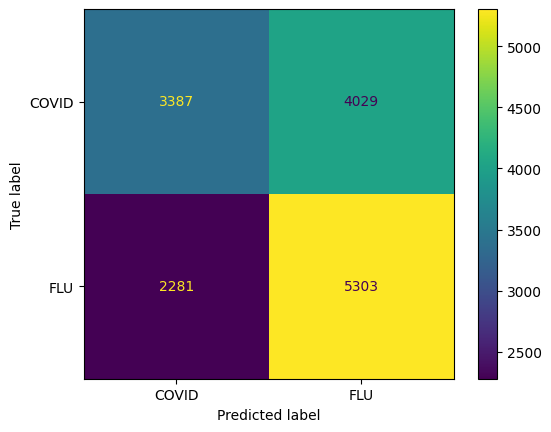

In [66]:
# ChatGPT [1] help for sklearn and confusion matrix syntax

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Training-test split on dataset
X_train, X_test, y_train, y_test = train_test_split(X, flipped_labels_25, test_size=0.3, random_state=42)

# Training model on optimal hyperparameter
classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(X_train, y_train)

# Predicting on test set
y_pred = classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

# Show the plot
import matplotlib.pyplot as plt
plt.show()

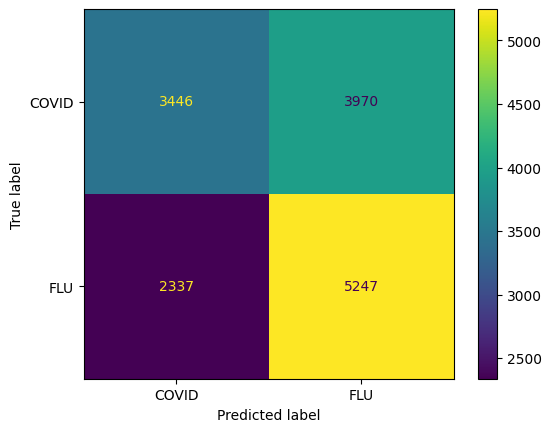

In [67]:
# ChatGPT [1] help for sklearn and confusion matrix syntax

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Training-test split on dataset
X_train, X_test, y_train, y_test = train_test_split(X_transformed, flipped_labels_25, test_size=0.3, random_state=42)

# Training model on optimal hyperparameter
classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(X_train, y_train)

# Predicting on test set
y_pred = classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

# Show the plot
import matplotlib.pyplot as plt
plt.show()

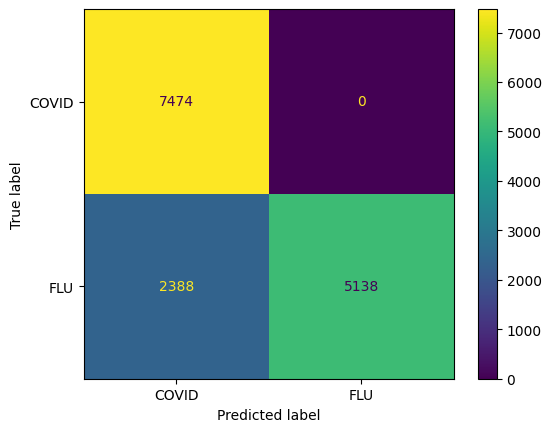

In [68]:
# ChatGPT [1] help for sklearn and confusion matrix syntax

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Training-test split on dataset
X_train, X_test, y_train, y_test = train_test_split(X, flipped_labels_50, test_size=0.3, random_state=42)

# Training model on optimal hyperparameter
classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(X_train, y_train)

# Predicting on test set
y_pred = classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

# Show the plot
import matplotlib.pyplot as plt
plt.show()

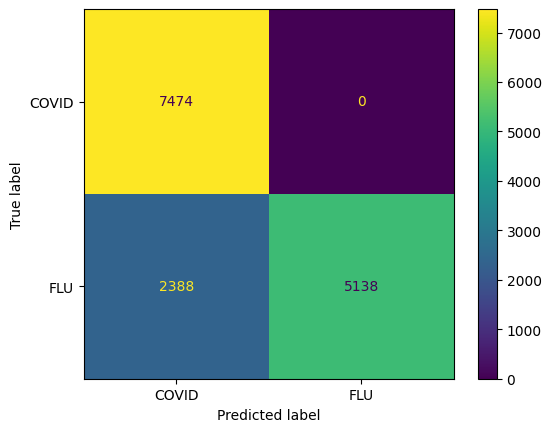

In [69]:
# ChatGPT [1] help for sklearn and confusion matrix syntax

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Training-test split on dataset
X_train, X_test, y_train, y_test = train_test_split(X_transformed, flipped_labels_50, test_size=0.3, random_state=42)

# Training model on optimal hyperparameter
classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(X_train, y_train)

# Predicting on test set
y_pred = classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

# Show the plot
import matplotlib.pyplot as plt
plt.show()

#### Multilayer Perceptron

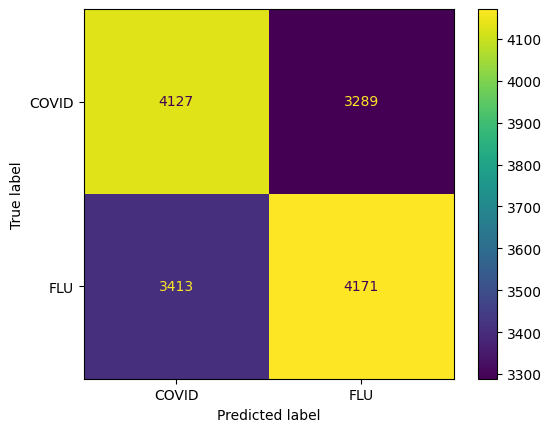

In [70]:
# Training-test split on dataset
X_train, X_test, y_train, y_test = train_test_split(X, flipped_labels_25, test_size=0.3, random_state=42)

# Training model on optimal hyperparameter
classifier = KNeighborsClassifier(n_neighbors=15)
classifier.fit(X_train, y_train)

# Predicting on test set
y_pred = classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

# Show the plot
import matplotlib.pyplot as plt
plt.show()

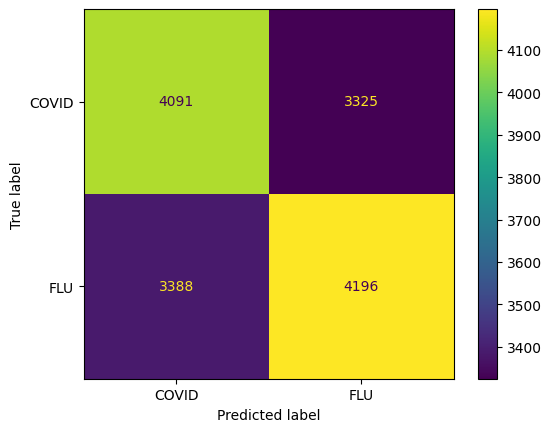

In [71]:
# Training-test split on dataset
X_train, X_test, y_train, y_test = train_test_split(X_transformed, flipped_labels_25, test_size=0.3, random_state=42)

# Training model on optimal hyperparameter
classifier = KNeighborsClassifier(n_neighbors=15)
classifier.fit(X_train, y_train)

# Predicting on test set
y_pred = classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

# Show the plot
import matplotlib.pyplot as plt
plt.show()

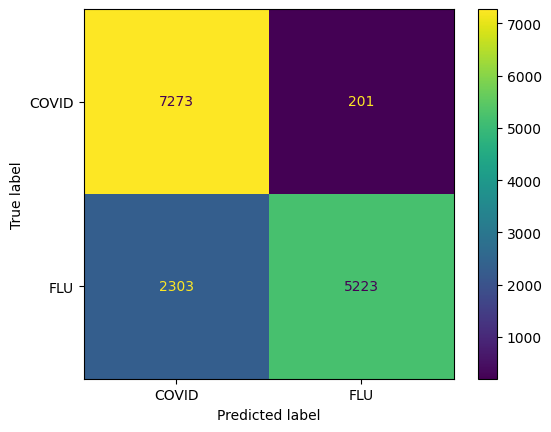

In [72]:
# Training-test split on dataset
X_train, X_test, y_train, y_test = train_test_split(X, flipped_labels_50, test_size=0.3, random_state=42)

# Training model on optimal hyperparameter
classifier = KNeighborsClassifier(n_neighbors=15)
classifier.fit(X_train, y_train)

# Predicting on test set
y_pred = classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

# Show the plot
import matplotlib.pyplot as plt
plt.show()

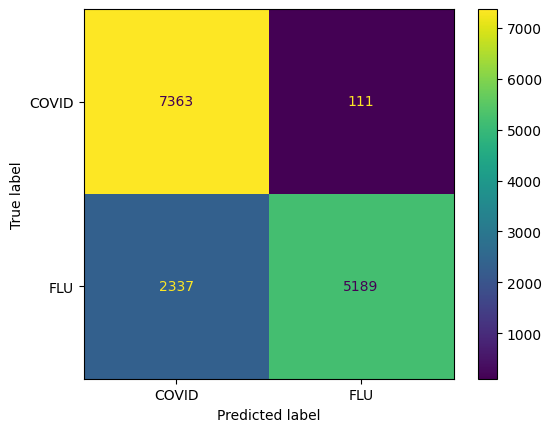

In [73]:
# Training-test split on dataset
X_train, X_test, y_train, y_test = train_test_split(X_transformed, flipped_labels_50, test_size=0.3, random_state=42)

# Training model on optimal hyperparameter
classifier = KNeighborsClassifier(n_neighbors=15)
classifier.fit(X_train, y_train)

# Predicting on test set
y_pred = classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

# Show the plot
import matplotlib.pyplot as plt
plt.show()